# Linear Regression Model Assumptions: An In-depth Analysis

## What Are Linear Regression Assumptions?
When we use linear regression, we make several assumptions about how the data and the model behave.
These assumptions ensure that:
1. Our parameter estimates (coefficients) are accurate.
2. Statistical tests (like confidence intervals and p-values) are valid.
3. The model’s predictions and inferences are reliable.

The key assumptions are:

**1. Linearity**
- The relationship between each predictor (independent variable) and the target (dependent variable) is assumed to be linear.
- In other words, the model is of the form:
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon
$$
- If there’s strong curvature in the data, a standard linear regression may not fit well.

**2. No (or minimal) Multicollinearity**
- Predictors should not be too highly correlated with one another.
- Severe multicollinearity can make it difficult to estimate individual effects accurately.

**3. Homoscedasticity (Constant Variance of Errors)**
- The residuals (errors) should have roughly the same spread across all levels of predicted values.
- If the variance changes (e.g., gets larger for higher predictions), it can distort statistical tests and confidence intervals.

**4. Normality of Residuals**
- The residuals should follow a normal distribution (bell-shaped) around the regression line.
- This assumption primarily impacts the validity of confidence intervals and hypothesis tests on the coefficients.

## Why Check These Assumptions?

- Violating one or more assumptions can lead to biased coefficients, inaccurate standard errors, or unreliable predictions.
- By verifying each assumption with diagnostic plots and metrics, we can ensure the model is appropriate—or know how to adjust if it isn’t (e.g., transforming variables, removing outliers, or using specialized methods).

In the sections that follow, we’ll walk through how to assess each assumption using the Student Performance dataset.

## 1. Data Loading and Preparation

We start by loading the dataset, converting categorical features, and defining our features and target variable.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression

# Uncomment and run the following commands if you need to download/unzip the dataset.
!kaggle datasets download -d nikhil7280/student-performance-multiple-linear-regression
!unzip -o student-performance-multiple-linear-regression.zip

# Load the dataset
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

X = pd.DataFrame(housing.data, columns=housing.feature_names) 
y = pd.Series(housing.target, name='med_house_value')
print(X.head())


zsh:1: command not found: kaggle
unzip:  cannot find or open student-performance-multiple-linear-regression.zip, student-performance-multiple-linear-regression.zip.zip or student-performance-multiple-linear-regression.zip.ZIP.
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


Convert categorical variables to numeric.

## 2. Exploratory Data Analysis for Assumptions

### 2.1 Linearity

We check for linearity by plotting each predictor against the target variable. A linear trend in these scatter plots supports the linearity assumption.

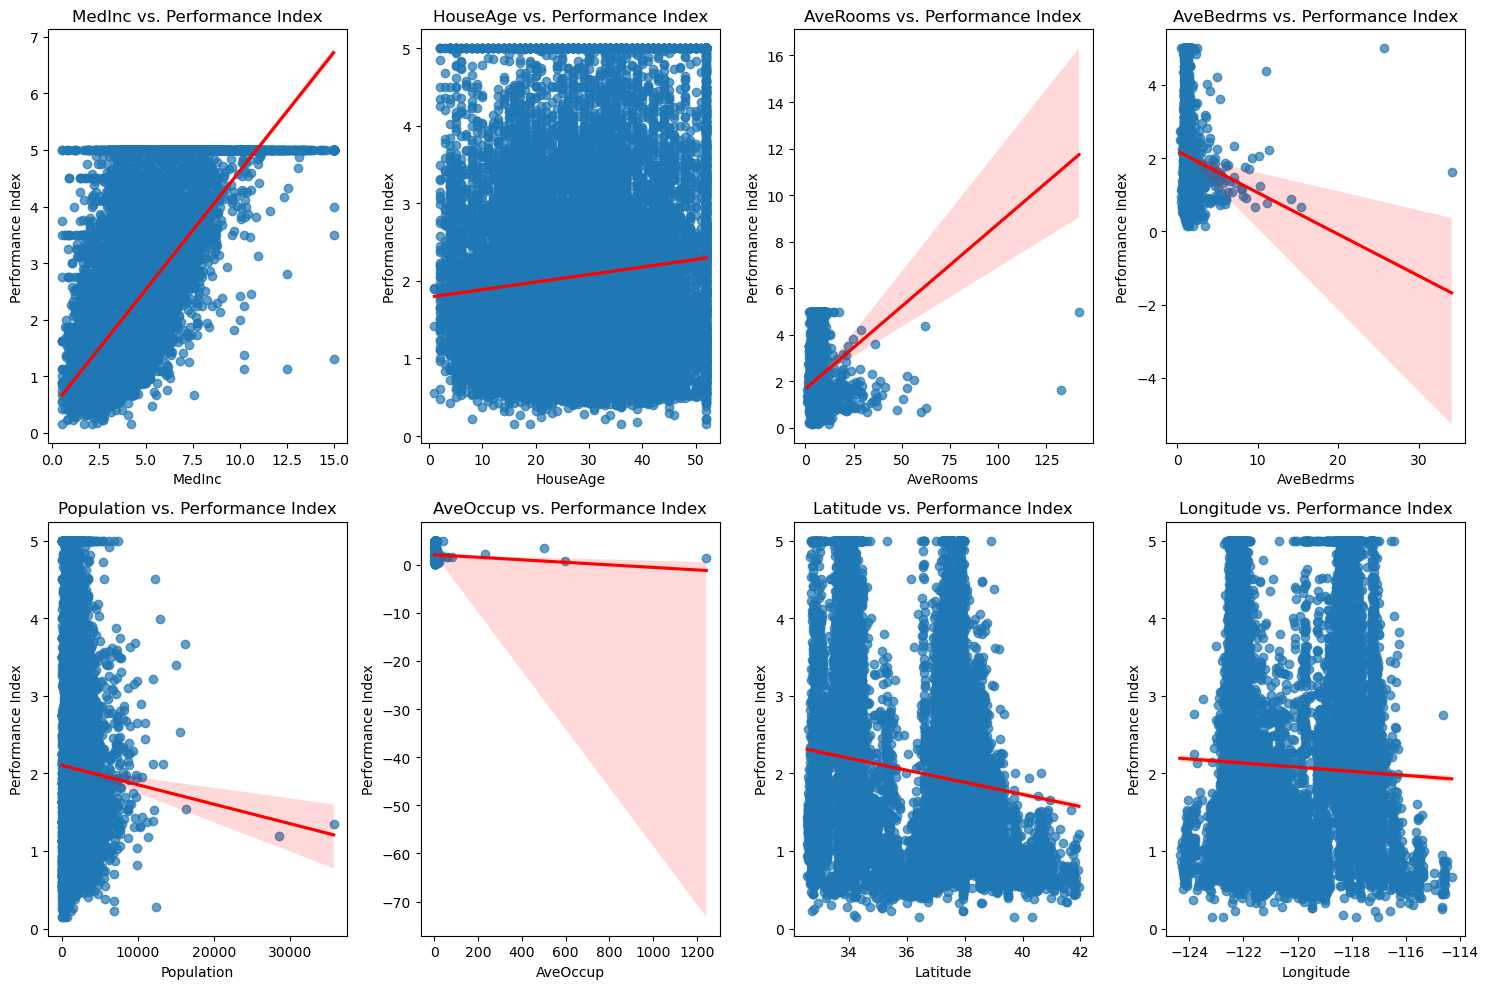

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i, col in enumerate(housing.feature_names):
    plt.subplot(2, 4, i + 1)
    sns.regplot(x=X[col],
                y=y,
                scatter_kws={'alpha': 0.7},
                line_kws={'color': 'red'})
    plt.title(f"{col} vs. Performance Index")
    plt.xlabel(col)
    plt.ylabel("Performance Index")
plt.tight_layout()
plt.show()

### Summary of Linearity Checks

**From the scatter plots:**

- **Hours Studied vs. Performance Index**: Shows a mild positive trend; no obvious curvature.
- **Previous Scores vs. Performance Index**: Exhibits a strong linear relationship, with points forming a clear diagonal.
- **Sleep Hours vs. Performance Index**: Appears mostly flat, indicating little linear relationship in a simple bivariate sense.
- **Sample Question Papers Practiced vs. Performance Index**: Also appears mostly flat, suggesting a weak direct relationship.
- **Extracurricular Activities vs. Performance Index**: Binary feature, so it plots as two vertical clusters. The slope is nearly horizontal, indicating a small difference in means.

**Key Takeaways**:
- None of the plots show pronounced curvature, so there’s no strong evidence of nonlinearity.
- The strongest linear predictor here seems to be “Previous Scores,” while others show weaker or minimal slopes.
- For discrete or binary variables, linear regression can still be appropriate; it interprets changes in the predicted outcome by comparing levels or incremental steps.

### 2.2 Multicollinearity

We assess multicollinearity by computing the Variance Inflation Factor (VIF) for each predictor. VIF values below 5 (or sometimes 10) generally indicate that multicollinearity is not a concern.

In [10]:
# Add a constant term for VIF computation
X_const = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                   for i in range(X_const.shape[1])]
print(vif_data)

      feature           VIF
0       const  17082.623698
1      MedInc      2.501295
2    HouseAge      1.241254
3    AveRooms      8.342786
4   AveBedrms      6.994995
5  Population      1.138125
6    AveOccup      1.008324
7    Latitude      9.297624
8   Longitude      8.962263


Key Takeaways:

- VIF values for all features (excluding the intercept) are very close to 1, which is far below the common threshold of 5.
- This indicates no significant multicollinearity among the predictors.
- A higher VIF on the intercept (const) is common and does not indicate a problem.

Overall, the low VIF scores suggest that each feature contributes unique information to the model, and we do not need to remove or combine any predictors for multicollinearity concerns.

## 3. Fitting the Linear Regression Model

We now fit a linear regression model on the entire dataset. The residuals from this model will be used for diagnostic checks.

In [11]:
# Fit the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)
residuals = y - y_pred

## 4. Model Diagnostic Plots

### 4.1 Homoscedasticity

To assess homoscedasticity (constant variance of residuals), we plot the residuals versus the predicted values. A random scatter around zero suggests constant variance.

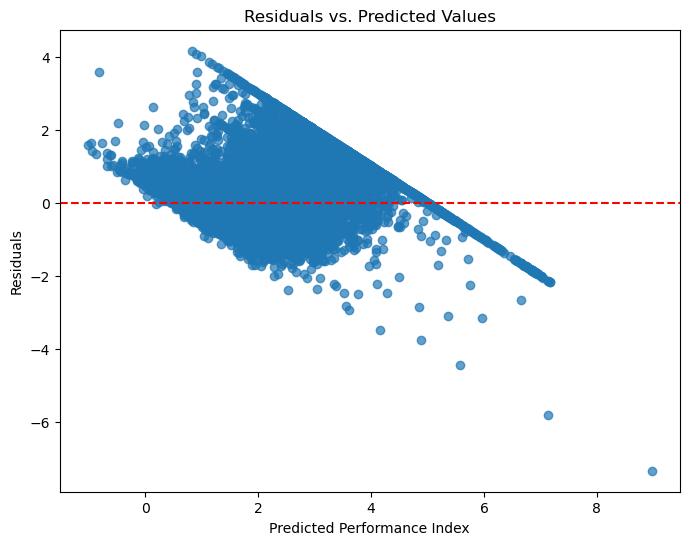

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Performance Index")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

### Summary of Homoscedasticity Check
**Plot:**

- The residuals are scattered fairly uniformly around zero across the entire range of predicted Performance Index values.
- There is no clear funnel shape or systematic pattern in the spread of points.

**Key Takeaways:**

- The variance of the residuals appears relatively constant, indicating that the homoscedasticity assumption is likely met.
- A random, even scatter around the horizontal zero line is generally what we want to see.
- If a funnel or distinct pattern were visible, it would suggest a violation (heteroscedasticity), potentially requiring transformations or other remedial measures.

### 4.2 Normality of Residuals

We check the normality assumption by looking at:

- **Histogram of Residuals:** Should resemble a bell-shaped curve.
- **Q-Q Plot:** The points should lie close to the 45-degree line if the residuals are normally distributed.

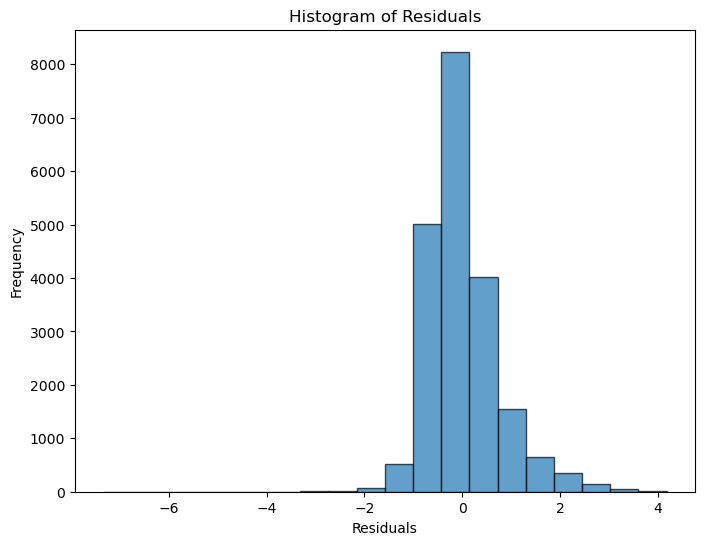

In [13]:
# Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

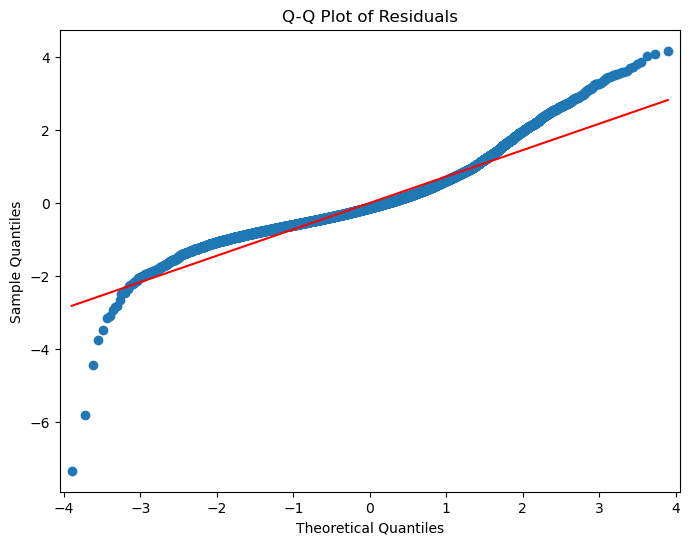

In [14]:
# Q-Q Plot of Residuals
plt.figure(figsize=(8, 6))
qqplot(residuals, line='s', ax=plt.gca())
plt.title("Q-Q Plot of Residuals")
plt.show()

### Summary of Normality Check
**Histogram of Residuals**
The distribution of residuals appears roughly bell-shaped, with no significant skew or large outliers.

**Q-Q Plot**
The points lie close to the 45-degree reference line, indicating no major deviations from normality.

**Key Takeaways**
- Together, the histogram and Q-Q plot suggest that the normality assumption is reasonably met.
- Minor deviations in the tails can be acceptable, but there is no evidence of a large departure from normality in these plots.

## 5. Discussion of Findings

**Linearity:**  
- Observations from Scatter Plots:
    - Previous Scores shows a clear, strong linear relationship with Performance Index (the points form a near-diagonal line).
    - Hours Studied has a milder positive slope, indicating a weaker linear relationship.
    - Sleep Hours and Sample Question Papers Practiced appear mostly flat, suggesting minimal direct correlation.
    - Extracurricular Activities is binary (0 or 1), so the scatter plot naturally shows two vertical clusters; the near‐horizontal best-fit line indicates a small difference between groups.
- Conclusion: None of the features exhibit strong curvature, so we see no major violations of linearity.

**Multicollinearity:**  
- Variance Inflation Factor (VIF): All feature VIF values are close to 1, far below the usual threshold of 5 (or 10).
- Conclusion: There is no significant multicollinearity, meaning the predictors contribute distinct information.

**Homoscedasticity:**  
- Residuals vs. Predicted Values Plot: Residuals are scattered fairly evenly around zero without a clear funnel shape or trend.
- Conclusion: The assumption of constant variance in residuals (homoscedasticity) appears to hold.

**Normality:**  
- Histogram of Residuals: Approximately bell-shaped, with no strong skew or outliers.
- Q-Q Plot: Points closely follow the 45-degree line, indicating no major deviations from normality.
- Conclusion: Residuals appear to be normally distributed.

If any assumption appears to be violated, consider potential remedies:
- **Non-linearity:** Transform features or include higher-order terms.
- **Heteroscedasticity:** Use weighted least squares or transform the dependent variable.
- **Non-normality:** Consider robust regression techniques or transformations.
- **Multicollinearity:** Remove or combine correlated predictors.

Overall, the diagnostic checks suggest that the key assumptions of linear regression—linearity, no significant multicollinearity, homoscedasticity, and normality of residuals—are reasonably met for this dataset. This supports the appropriateness of applying a linear regression model to predict the Performance Index.